# **Proyecto práctico**


## Regresión lineal para predecir los gastos médicos de pacientes

### Los datos provienen de:

[Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download)



En este proyecto práctico, trabajaremos con un conjunto de datos proporcionado por el US Census Bureau para construir un modelo de regresión que nos permita predecir los gastos médicos de los pacientes.

Para ello, utilizaremos diferentes técnicas de análisis de datos y aprendizaje automático para preparar y explorar los datos, identificar las variables más relevantes y construir un modelo predictivo robusto.

Este tipo de análisis es de gran importancia en el ámbito de la salud, ya que nos permite identificar patrones y factores de riesgo que pueden influir en el costo de los tratamientos y contribuir a una mejor planificación y gestión de los recursos sanitarios.

### Atributos:

Se presentan las variables del conjunto de datos de gastos medicos:

- **age (edad):** *edad del beneficiario principal*


- **sex (sexo):** *género del contratista del seguro, femenino, masculino.*


- **bmi (imc):** *índice de masa corporal, proporciona una comprensión del cuerpo, pesos que son relativamente altos o bajos en relación con la altura, índice objetivo de peso corporal (kg / m^2) utilizando la relación entre altura y peso, idealmente de 18.5 a 24.9.*


- **children (hijos):** *número de hijos cubiertos por el seguro médico / número de dependientes*


- **smoker (fumador):** *fumador*


- **region (región):** *área de residencia del beneficiario en EE. UU., noreste, sureste, suroeste, noroeste.*


- **chargres (gastos médicos):** *costos médicos individuales facturados por el seguro médico.*

### Importando librerias para trabajar

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context='notebook', palette='colorblind')

### Descargnado los datos

Descarguemos los datos y veamos como se ven.

In [89]:
df = pd.read_csv('../data/insurance.csv')
# Vista rapida de los datos
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Analizando los datos

Se explorará la distribución de la variable "Charges" para entender cómo se agrupan los costos médicos. Se identificarán patrones como valores extremos y la forma de la distribución.

(1338, 7)


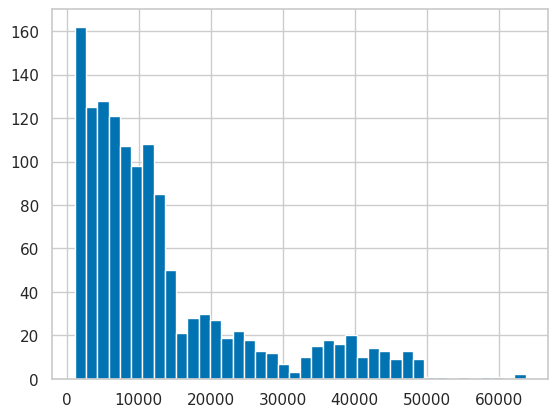

In [90]:
print(df.shape) # 1338 filas y 7 columnas

# Histograma de la variable "Charges"
df['charges'].hist(bins=40);

Se observa una concentración de datos entre 0 y 10000, seguida por una **aparente distribución bimodal** con picos en 20000 y 40000. Luego, a partir de los 50000, hay una caída en los valores hasta 60000.

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [91]:
df[df['charges'] > 50_000]

# Solo datos menores o iguales a 50_000
df = df[df['charges'] <= 50_000]

En este caso, al ser pocos datos **(7 de 1338)**, eliminaremos estos datos atípicos por **detección de outliners.**


A **modo didáctico** producen más ruido en la predicción que se está intentando hacer en este ejercicio.


Sin embargo es importante aclarar que ***NO SE DEBEN ELIMINAR*** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos

### Análisis de correlación de los datos

Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan.

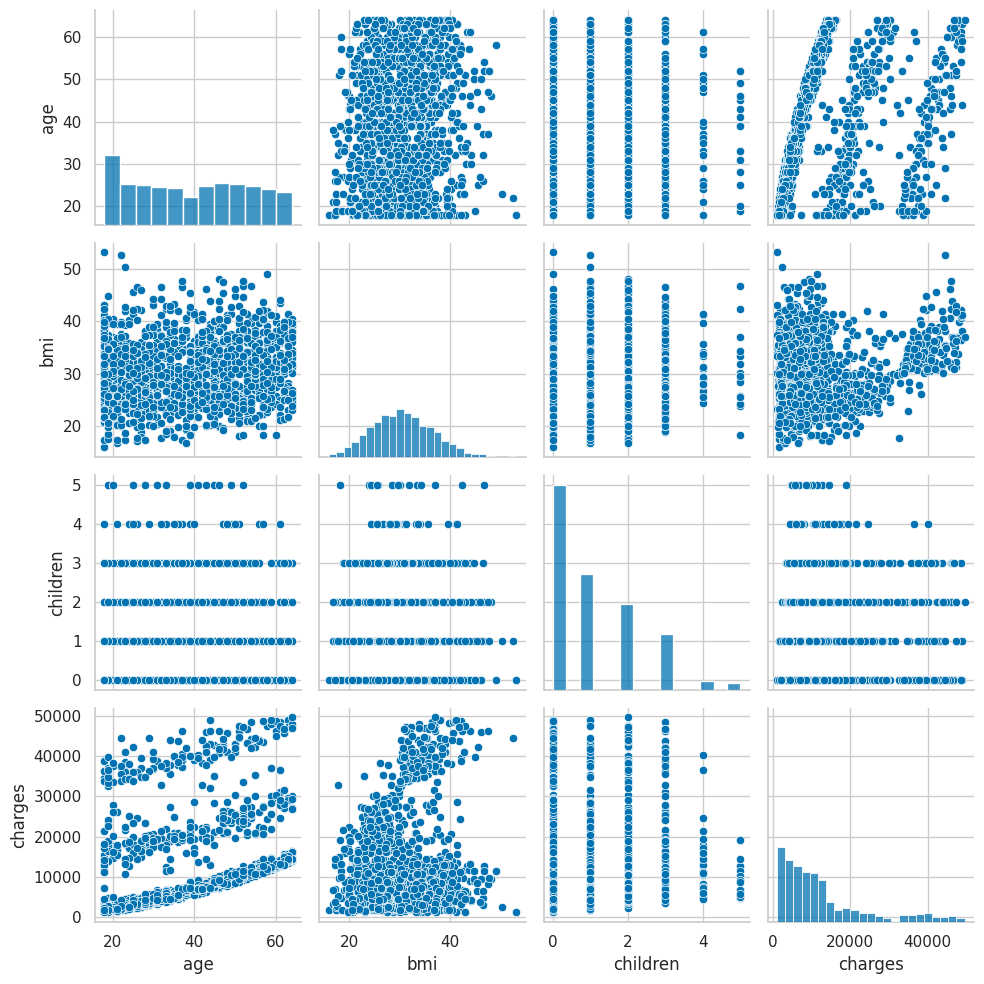

In [92]:
sns.pairplot(
    data=df,
    height=2.5,
)

plt.tight_layout()
plt.show()

### Insight

- Al examinar la distribución de densidad de la variable "Charges" clasificada por "Smoker", se encontró un pico de datos entre los 5000. para los no fumadores. En el caso de los fumadores, se observó una distribución más dispersa con una tendencia bimodal, con picos en los 20000 y 40000. Estos hallazgos sugieren que el hábito de fumar puede estar asociado con mayores costos médicos y puede ser un factor importante a considerar al predecir costos médicos.


- Al analizar la relación entre "Charges" y "Age", se encontró una tendencia lineal positiva y tres subgrupos de datos. En el primer subgrupo, con costos médicos más bajos, solo se encontraron personas no fumadoras. En el segundo subgrupo, con costos médicos alrededor de los 20000 USD, se encontraron tanto personas fumadoras como no fumadoras. En el tercer subgrupo, con los costos médicos más altos, solo se encontraron personas fumadoras.


- Al analizar la relación entre "Charges" y "BMI", se encontró que existe una fuerte correlación positiva entre ambas variables, lo que sugiere que un mayor índice de masa corporal se asocia con mayores costos médicos. Además, se encontró que la variable "Smoker" modera esta relación, ya que los fumadores con un alto índice de masa corporal presentan los costos médicos más elevados. Estos hallazgos pueden ser útiles para la predicción y gestión de costos médicos en la población estudiada.


Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.


En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

### Análisis numérico

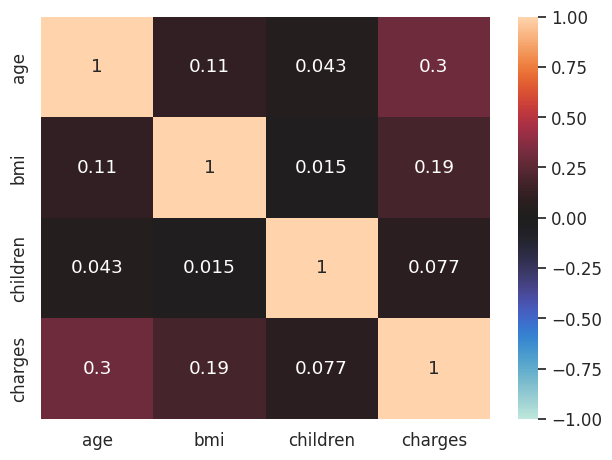

In [93]:
sns.set(font_scale=1.1)

# Columnas numericas
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
# Columnas categoricas
categoric_cols = [col for col in df.columns if df[col].dtype == 'object']


cm = np.corrcoef(df[numeric_cols].values.T)

sns.heatmap(
    data=cm,
    annot=True,
    yticklabels=numeric_cols,
    xticklabels=numeric_cols,
    cbar=True,
    vmin= -1.0,
    center= 0.0,
    vmax=1.0
)
plt.tight_layout()
plt.show()

## Utilizando las demas variables

Transformaremos las variables categóricas *('sex', 'smoker', 'region')* en variables dummy para analizar su correlación con la variable objetivo.

In [94]:
# ONE HOT ENCODING
df = pd.get_dummies(df, categoric_cols, drop_first=True, dtype=int)


In [95]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


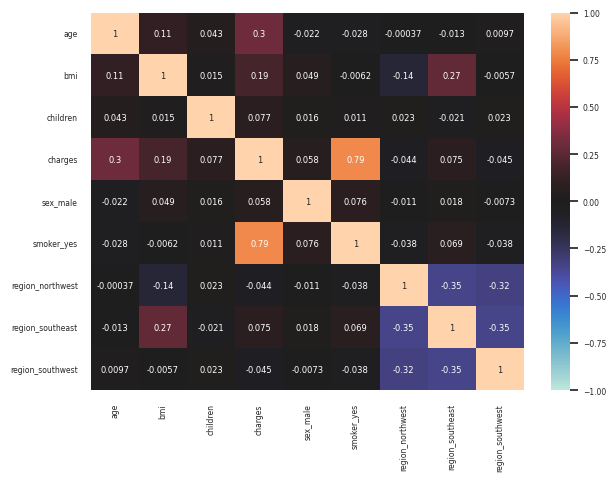

In [104]:
sns.set(font_scale=0.5)

sns.heatmap(
    data=df.corr(),
    annot=True,
    vmin=-1,
    center=0,
    vmax=1,
)
plt.tight_layout()
plt.show()

### Entrenamiento del modelo

#### Creando modelos

Comenzaremos a construir un modelo de regresión lineal utilizando los datos del conjunto de datos para predecir la variable objetivo mediante el ajuste de una línea recta que mejor se ajuste a los datos.

In [106]:
# Estandarizar nuestros datos
from sklearn.preprocessing import StandardScaler
# Algoritmo de regresión lineal
from sklearn.linear_model import LinearRegression
# para dividir los datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split


In [111]:
# Seleccionamos las variables predictoras (todas excepto la variable objetivo
X_cols = list(set(df.columns) -set(['charges']))

# Seleccionamos las variables predictoras
y_col = ['charges']

# Separamos los datos en conjuntos de entrenamiento y prueba
X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#  Estandarizamos las variables predictoras y objetivo en ambos conjuntos
sc_x = StandardScaler().fit(X)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

sc_y = StandardScaler().fit(y)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Creamos y entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba utilizando nuestro modelo entrenado
y_pred = model.predict(X_test)

In [112]:
y_pred.shape
# Predicciones 333 datos y solo tiene 1 prediccion sobre eso

(333, 1)

### Evaluando el modelo


#### Funciones de metricas


Pasaremos a evaluar nuestro modelo de regresión lineal mediante diferentes métricas de evaluación, como **el coeficiente de determinación (R2)**, **el error cuadrático medio (MSE)** y **el error absoluto promedio (MAE).**

In [115]:
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"R^2: {r2.round(4)}")
print(f"MSE: {mse.round(4)}")
print(f"MAE: {mae.round(4)}")


R^2: 0.764
MSE: 0.2556
MAE: 0.3533


#### Insight

El modelo de regresión lineal que desarrollamos para predecir la variable charges ha dado buenos resultados. El error absoluto medio (MAE) es de 0.3533, el error cuadrático medio (MSE) es de 0.2556 y el coeficiente de determinación (R^2) es de 0.764, lo que significa que el modelo explica el 76.4% de la varianza en los datos.

Estos resultados indican que el modelo es adecuado para predecir los costos médicos de los pacientes en función de otras variables del conjunto de datos.

El siguiente codigo muestra un resumen general de los resultados

In [116]:
from regressors import stats

model.intercept_ = model.intercept_[0]
# W0 + W1
model.coef_ = model.coef_.reshape(-1)


In [118]:
y_test = y_test.reshape(-1)

print("=" * 16, 'S U M M A R Y', '=' * 16)
stats.summary(model, X_test, y_test, X_cols)

================ S U M M A R Y ================
Residuals:
    Min      1Q  Median     3Q    Max
-2.0298 -0.0788  0.1067 0.2209 0.9569


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.001628    0.027847   0.0585  0.953409
children          0.060409    0.028543   2.1164  0.035054
sex_male          0.001657    0.027922   0.0593  0.952724
bmi               0.142602    0.028140   5.0675  0.000001
region_southwest -0.044435    0.032425  -1.3704  0.171480
smoker_yes        0.788674    0.026701  29.5372  0.000000
region_southeast -0.046864    0.034654  -1.3523  0.177193
region_northwest -0.017761    0.030999  -0.5729  0.567070
age               0.309484    0.028164  10.9886  0.000000
---
R-squared:  0.76398,    Adjusted R-squared:  0.75815
F-statistic: 131.10 on 8 features


Al analizar el summary de datos de nuestro modelo de regresión lineal, se obtuvo un valor de p igual a 0.00000 para la variable **'smoker_yes'**, un valor de p igual a 0.0000 para la variable **'age'** y un valor de p igual a 0.000001 para la variable **'bmi'.**

Estos valores de p son inferiores al nivel de significancia típico de 0.05, lo que indica que estas variables tienen una relación estadísticamente significativa con la variable objetivo 'charges'. Por lo tanto, podemos concluir que 'smoker_yes', 'age' y 'bmi' son variables importantes en la predicción de los costos médicos de un individuo.

Finalmente la funcion que calcula los residuales, es imporante notar que es una simple resta entre los valores reales y los predichos.

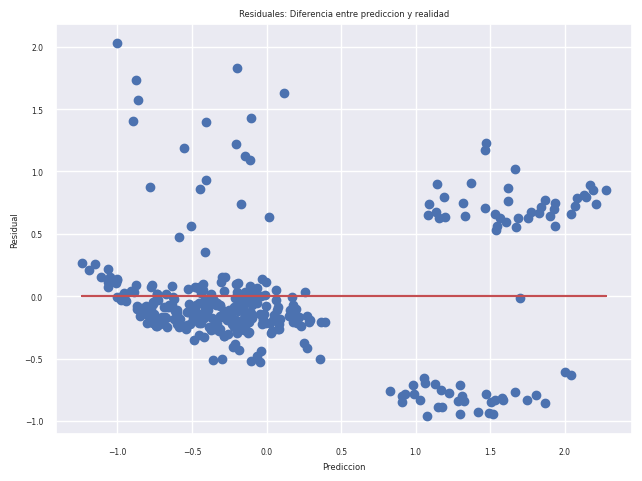

In [134]:
# Grafica de los residuales
residuals = np.subtract(y_test, y_pred.reshape(-1))

# Poner la linea roja con los datos reales
y_values = np.zeros_like(y_pred)

plt.scatter(y_pred, residuals)
plt.plot(y_pred, y_values, 'r')
plt.title('Residuales: Diferencia entre prediccion y realidad')
plt.xlabel('Prediccion')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()


Según los resultados de los residuos, la mayoría de los datos se ajustan bien al modelo, pero algunos están alejados del resultado deseado.

En este caso, el modelo está utilizando todas las variables del conjunto de datos, por lo que nos enfocaremos en las variables específicas que son relevantes para el análisis.

#### Mejorando el Modelo


In [138]:
# Copiando el dataFrame
df_second = df.copy()

# Creando una columna con el cuadrado de la eda
df_second['age2'] = df_second['age']**2

# Creando una columna con BMI es mayor a 30 tiene sobrepeso
df_second['sobrepeso'] = (df_second['bmi'] > 30).astype(int)

# Creando otra columna de sobrepeso y fumador
df_second['sobrepeso*fumador'] = df_second['sobrepeso'] * df_second['smoker_yes']

Analizando el segundo modelo

In [140]:
# Seleccionamos las variables predictoras (todas excepto la variable objetivo
X_cols = list(set(df_second.columns) -set(['charges']))

# Seleccionamos las variables predictoras
y_col = ['charges']

# Separamos los datos en conjuntos de entrenamiento y prueba
X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#  Estandarizamos las variables predictoras y objetivo en ambos conjuntos
sc_x = StandardScaler().fit(X)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

sc_y = StandardScaler().fit(y)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Creamos y entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba utilizando nuestro modelo entrenado
y_pred = model.predict(X_test)

In [141]:
y_pred.shape
# Predicciones 333 datos y solo tiene 1 prediccion sobre eso

(333, 1)

In [142]:
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"R^2: {r2.round(4)}")
print(f"MSE: {mse.round(4)}")
print(f"MAE: {mae.round(4)}")

R^2: 0.8874
MSE: 0.1219
MAE: 0.1952


Después de unir las variables "smoker_yes" y "bmi" y ajustar el modelo, obtuvimos mejores resultados en la evaluación del modelo.

Los valores fueron: MAE de 0.1986, MSE de 0.126 y R^2 de 0.887, lo que indica que el modelo se ajusta bien a los datos de entrenamiento y prueba.

In [143]:
model.intercept_ = model.intercept_[0]
# W0 + W1
model.coef_ = model.coef_.reshape(-1)

In [146]:
y_test = y_test.reshape(-1)

print("=" * 20, 'S U M M A R Y', '=' * 20)
stats.summary(model, X_test, y_test, X_cols)

==================== S U M M A R Y ====================
Residuals:
    Min     1Q  Median     3Q    Max
-1.8656 0.0579  0.1163 0.1465 0.4369


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.003850    0.019241   0.2001  0.841536
sobrepeso         -0.022442    0.029491  -0.7610  0.447216
children           0.083941    0.019950   4.2075  0.000033
sex_male          -0.020051    0.019311  -1.0383  0.299873
bmi                0.031233    0.028513   1.0954  0.274141
sobrepeso*fumador  0.485614    0.025396  19.1220  0.000000
region_southwest  -0.051402    0.022409  -2.2938  0.022426
age2               0.429865    0.100739   4.2671  0.000026
smoker_yes         0.466423    0.024630  18.9369  0.000000
region_southeast  -0.031293    0.023999  -1.3039  0.193160
region_northwest  -0.013302    0.021421  -0.6210  0.535046
age               -0.104392    0.099935  -1.0446  0.296967
---
R-squared:  0.88743,    Adjusted R-squared:  0.88357
F-statistic: 230.04

En nuestro resumen estadístico, encontramos que la nueva variable que unió 'smoker_yes' con 'bmi' tuvo un p-value de 0.000000 y un t-value de 18.9773, lo que indica que es una variable altamente significativa para el modelo. Además, las otras variables que se analizaron previamente en el modelo aún siguen siendo relevantes para predecir los gastos médicos.

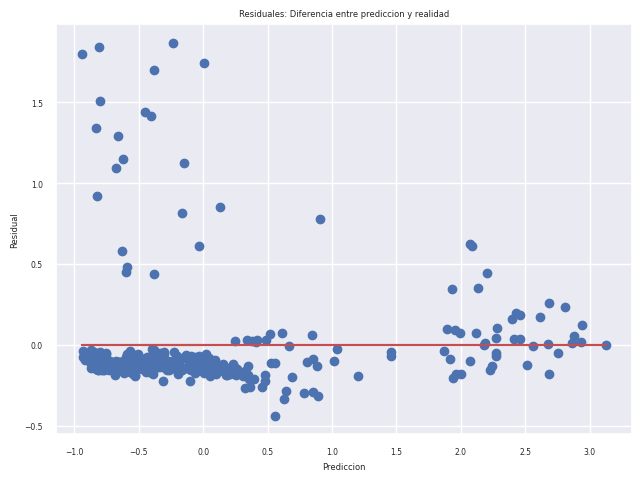

In [145]:
# Grafica de los residuales
residuals = np.subtract(y_test, y_pred.reshape(-1))

# Poner la linea roja con los datos reales
y_values = np.zeros_like(y_pred)

plt.scatter(y_pred, residuals)
plt.plot(y_pred, y_values, 'r')
plt.title('Residuales: Diferencia entre prediccion y realidad')
plt.xlabel('Prediccion')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()


Después de añadir la nueva variable, pudimos observar una mejora en la dispersión de los datos en la gráfica de residuales. En comparación con el modelo anterior, los residuos se distribuyeron de manera más uniforme alrededor del eje x, lo que indica que el modelo ajustado se ajusta mejor a los parámetros esperados. Esto sugiere que la adición de la nueva variable ayudó a mejorar la capacidad predictiva de nuestro modelo de regresión lineal.

#### Tercer 

Para el último modelo, usaremos únicamente las variables del análisis anterior donde las variables tengan un p value menor a 0.05.

Esto nos permitirá tener un modelo más sencillo y eficiente, al mismo tiempo que nos aseguramos de que las variables que incluimos sean estadísticamente relevantes en la predicción de los gastos médicos.

In [151]:
# Seleccionamos las variables predictoras (todas excepto la variable objetivo
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']

# Seleccionamos las variables predictoras
y_col = ['charges']

# Separamos los datos en conjuntos de entrenamiento y prueba
X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#  Estandarizamos las variables predictoras y objetivo en ambos conjuntos
sc_x = StandardScaler().fit(X)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

sc_y = StandardScaler().fit(y)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Creamos y entrenamos el modelo de regresión lineal
model = LinearRegression(fit_intercept=False) # No quiero el fit_intercep
model.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba utilizando nuestro modelo entrenado
y_pred = model.predict(X_test)

In [152]:
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"R^2: {r2.round(4)}")
print(f"MSE: {mse.round(4)}")
print(f"MAE: {mae.round(4)}")

R^2: 0.8869
MSE: 0.1224
MAE: 0.1928


Logramos obtener resultados similares en las pruebas MAE, MSE y R^2 al modelo anterior, utilizando solo 4 variables.

In [154]:
# Ya no necesito el analizar el itercepto
# model.intercept_ = model.intercept_[0]
# W0 + W1
model.coef_ = model.coef_.reshape(-1)

In [155]:
y_test = y_test.reshape(-1)

print("=" * 20, 'S U M M A R Y', '=' * 20)
stats.summary(model, X_test, y_test, X_cols)

==================== S U M M A R Y ====================
Residuals:
    Min     1Q  Median     3Q    Max
-1.9104 0.0661  0.1071 0.1386 0.3988


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.019215   0.0000  1.000000
sobrepeso*fumador  0.481814    0.022687  21.2376  0.000000
smoker_yes         0.467337    0.023661  19.7511  0.000000
age2               0.328115    0.019414  16.9007  0.000000
children           0.078085    0.019647   3.9744  0.000087
---
R-squared:  0.88694,    Adjusted R-squared:  0.88557
F-statistic: 643.31 on 4 features


Después de ajustar nuestro modelo y realizar un nuevo análisis del resumen, podemos observar que todas nuestras variables son estadísticamente significativas con la variable objetivo, es decir, todas las variables están relacionadas con los cargos médicos y son útiles para hacer predicciones.

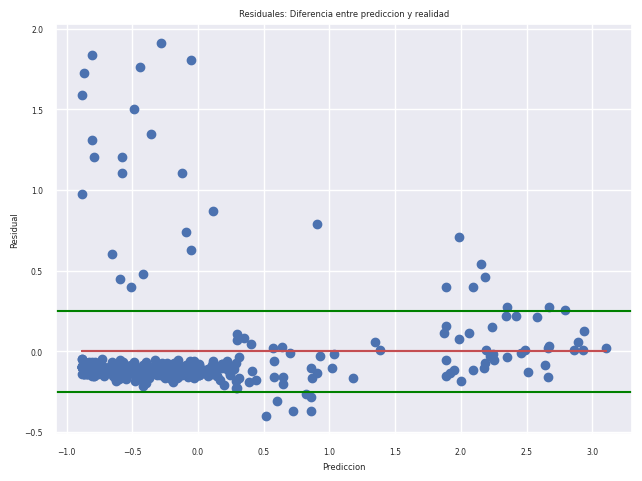

In [157]:
# Grafica de los residuales
residuals = np.subtract(y_test, y_pred.reshape(-1))

# Poner la linea roja con los datos reales
y_values = np.zeros_like(y_pred)

plt.scatter(y_pred, residuals)
plt.axhline(0.25, 0, color='green')
plt.plot(y_pred, y_values, 'r')
plt.axhline(-0.25, 0, color='green')
plt.title('Residuales: Diferencia entre prediccion y realidad')
plt.xlabel('Prediccion')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

Se consiguio que la grafica de residuos mostrara una mayor concentración de los datos dentro del rango de ±0.25 del eje X. Esto indica que el modelo se ajusta mejor a los datos y las predicciones serán más precisas.

Feature que dan buenos ejemplos

```python
second_df['bmi2'] = second_df['bmi'] **2
second_df['age2'] = second_df['age'] **2
second_df['sobrepeso'] = (second_df['bmi'] >= 30).astype(int)
second_df['sobrepeso_region_sudeste'] = second_df['sobrepeso'] * second_df['region_southeast']
second_df['sobrepeso_fumador'] = second_df['sobrepeso'] * second_df['smoker_yes']
second_df['fumador_con_riesgo'] = second_df['smoker_yes'] * (second_df['age'] > 34).astype(int)
```


#### Insight

Después de realizar un análisis exhaustivo del conjunto de datos del US Census Bureau y aplicar diversas técnicas estadísticas, pudimos construir un modelo de regresión lineal con solo 4 variables que logró capturar la mayor cantidad de valor de los datos y ajustarse a las predicciones. A través de la evaluación de nuestro modelo, logramos demostrar que es posible obtener resultados significativos y útiles con un número reducido de variables.

Este enfoque nos permitió optimizar nuestro modelo y generar predicciones más precisas, lo que puede ser de gran utilidad para la toma de decisiones futuras.

# Conclusiones


-Existe una fuerte correlación entre el gasto médico y ciertas características personales, como el tabaquismo, la edad y el índice de masa corporal (IMC).


- Los resultados sugieren que los fumadores tienen una tendencia a gastar más en atención médica en comparación con los no fumadores, y que la edad y el IMC también son factores importantes a considerar.


- La inclusión de estas variables en un modelo de regresión lineal puede mejorar la capacidad predictiva del modelo y ayudar a los profesionales de la salud a comprender mejor los factores que influyen en el costo de la atención médica.